In [1]:
%reload_ext autoreload
%autoreload 2

In [3]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
    custom_plots,
)
from ripple_heterogeneity.assembly import assembly_reactivation,find_sig_assembly
from ripple_heterogeneity.readout import ca1_assembly_downstream_psth, assembly_multi_region
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import os
from scipy import stats

from statannot import add_stat_annotation
from statannotations.Annotator import Annotator

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [4]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions

,basepath
0,Z:\Data\AYAold\AYA7\day19
1,Z:\Data\AYAold\AYA7\day20
2,Z:\Data\AYAold\AYA7\day24
3,Z:\Data\AYAold\AYA7\day25
4,Z:\Data\AYAold\AYA7\day27
...,...
105,Z:\Data\FujisawaS\EE\EE0705fm
106,Z:\Data\FujisawaS\EE\EE0706fm
107,Z:\Data\FujisawaS\EE\EE0708fm
108,Z:\Data\HMC1\day12


In [104]:
from ripple_heterogeneity.utils import functions, loading, compress_repeated_epochs

def run(
    basepath,
    regions="CA1",# not used
    target_regions=["CA1", "PFC", "EC1|EC2|EC3|EC4|EC5|MEC"],
    putativeCellType="Pyr",
    weight_dt=0.02,  # dt in seconds for binning st to get weights for each assembly
    verbose=False,  # print out progress
    rip_exp_start=0.05,  # ripple expansion start, in seconds, how much to expand ripples
    rip_exp_stop=0.2,  # ripple expansion stop, in seconds, how much to expand ripples
    min_cells=5,  # minimum number of cells in analysis (n deep, n superficial, n cortex)
):

    epoch_df = loading.load_epoch(basepath)
    epoch_df = compress_repeated_epochs.main(epoch_df, epoch_name="sleep")
    idx = functions.find_pre_task_post(epoch_df.environment)
    if idx is None:
        return None

    cm = pd.DataFrame()
    assembly_act = []
    assembly_act_all = []
    for regions in target_regions:

        # initialize session
        m1 = assembly_reactivation.AssemblyReact(
            basepath,
            brainRegion=regions,
            putativeCellType=putativeCellType,
            weight_dt=weight_dt,
        )

        # load data
        m1.load_data()

        # restrict to pre/task/post epochs
        m1.restrict_epochs_to_pre_task_post()

        if m1.st.n_active < 5:
            continue

        # detect assemblies during the task
        m1.get_weights(m1.epochs[1])

        if len(m1.patterns) == 0:
            print("No patterns found")
            continue

        # extend ripples to include some extra time
        m1.ripples = m1.ripples.expand(rip_exp_start, direction="start")
        m1.ripples = m1.ripples.expand(rip_exp_stop, direction="stop")
        ac = m1.get_assembly_act(epoch=m1.ripples)
        assembly_act.append(ac)
        assembly_act_all.append(ac.data)
        cm = pd.concat([cm, m1.cell_metrics], ignore_index=True)

    return assembly_act, np.vstack(assembly_act_all), cm, m1

assembly_act, assembly_act_all, cm, m1 = run(r"Z:\Data\FujisawaS\EE\EE0706fm")

In [111]:
sns.heatmap(assembly_act_all,vmin=100,vmax=100)

In [108]:
assembly_act, m1.epochs

([<AnalogSignalArray at 0x16b8f4842e0: 5 signals (6,457 segments)> for a total of 43:10:631 minutes,
  <AnalogSignalArray at 0x16c3ed6b520: 4 signals (6,457 segments)> for a total of 43:10:631 minutes],
 <EpochArray at 0x16c3ed73f40: 3 epochs> of length 1:34:43:371 hours)

In [102]:
assembly_act[0].data.shape

(5, 1498520)

In [80]:
signal_df = pd.DataFrame()
signal_df["ca1_act_1"] = assembly_act[0][m1.epochs[1:]].data[0]
signal_df["ca1_act_2"] = assembly_act[0][m1.epochs[1:]].data[1]
signal_df["ca1_act_3"] = assembly_act[0][m1.epochs[1:]].data[2]
signal_df["ca1_act_4"] = assembly_act[0][m1.epochs[1:]].data[3]
signal_df["ca1_act_5"] = assembly_act[0][m1.epochs[1:]].data[4]

signal_df["pfc_act_1"] = assembly_act[1][m1.epochs[1:]].data[0]
signal_df["pfc_act_2"] = assembly_act[1][m1.epochs[1:]].data[1]
signal_df["pfc_act_3"] = assembly_act[1][m1.epochs[1:]].data[2]
signal_df["pfc_act_4"] = assembly_act[1][m1.epochs[1:]].data[3]

signal_df_cor = signal_df.corr()

<AxesSubplot:>

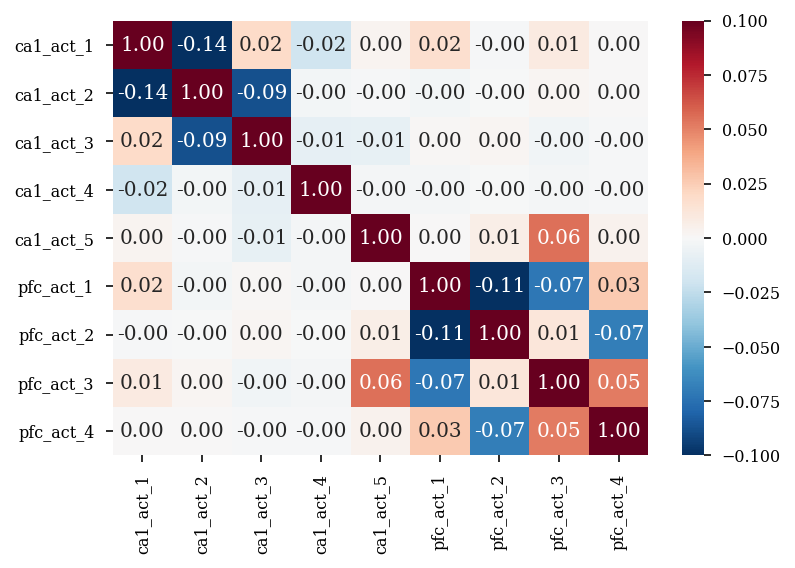

In [82]:
sns.heatmap(signal_df_cor,annot=True, fmt=".2f", cmap="RdBu_r",vmax=0.1, vmin=-0.1)

<AxesSubplot:>

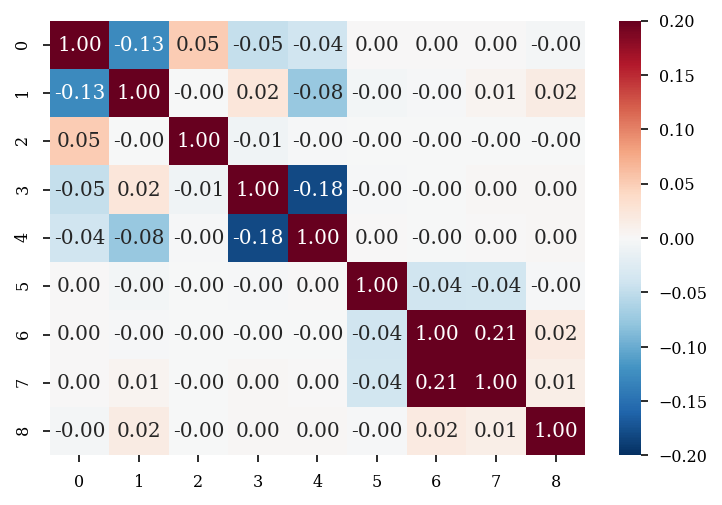

In [62]:
cor_mat = np.corrcoef(assembly_act[0].data,assembly_act[1].data)
sns.heatmap(cor_mat, annot=True, fmt=".2f", cmap="RdBu_r",vmax=0.2, vmin=-0.2)

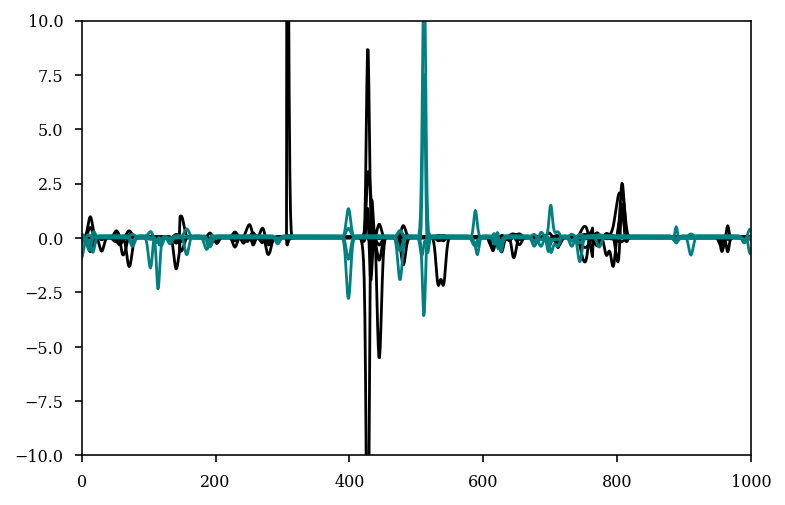

In [54]:
plt.plot(assembly_act[0].data.T,color="k")
plt.plot(assembly_act[1].data.T,color="teal")
plt.xlim(0,1000)
plt.ylim(-10,10)
plt.show()

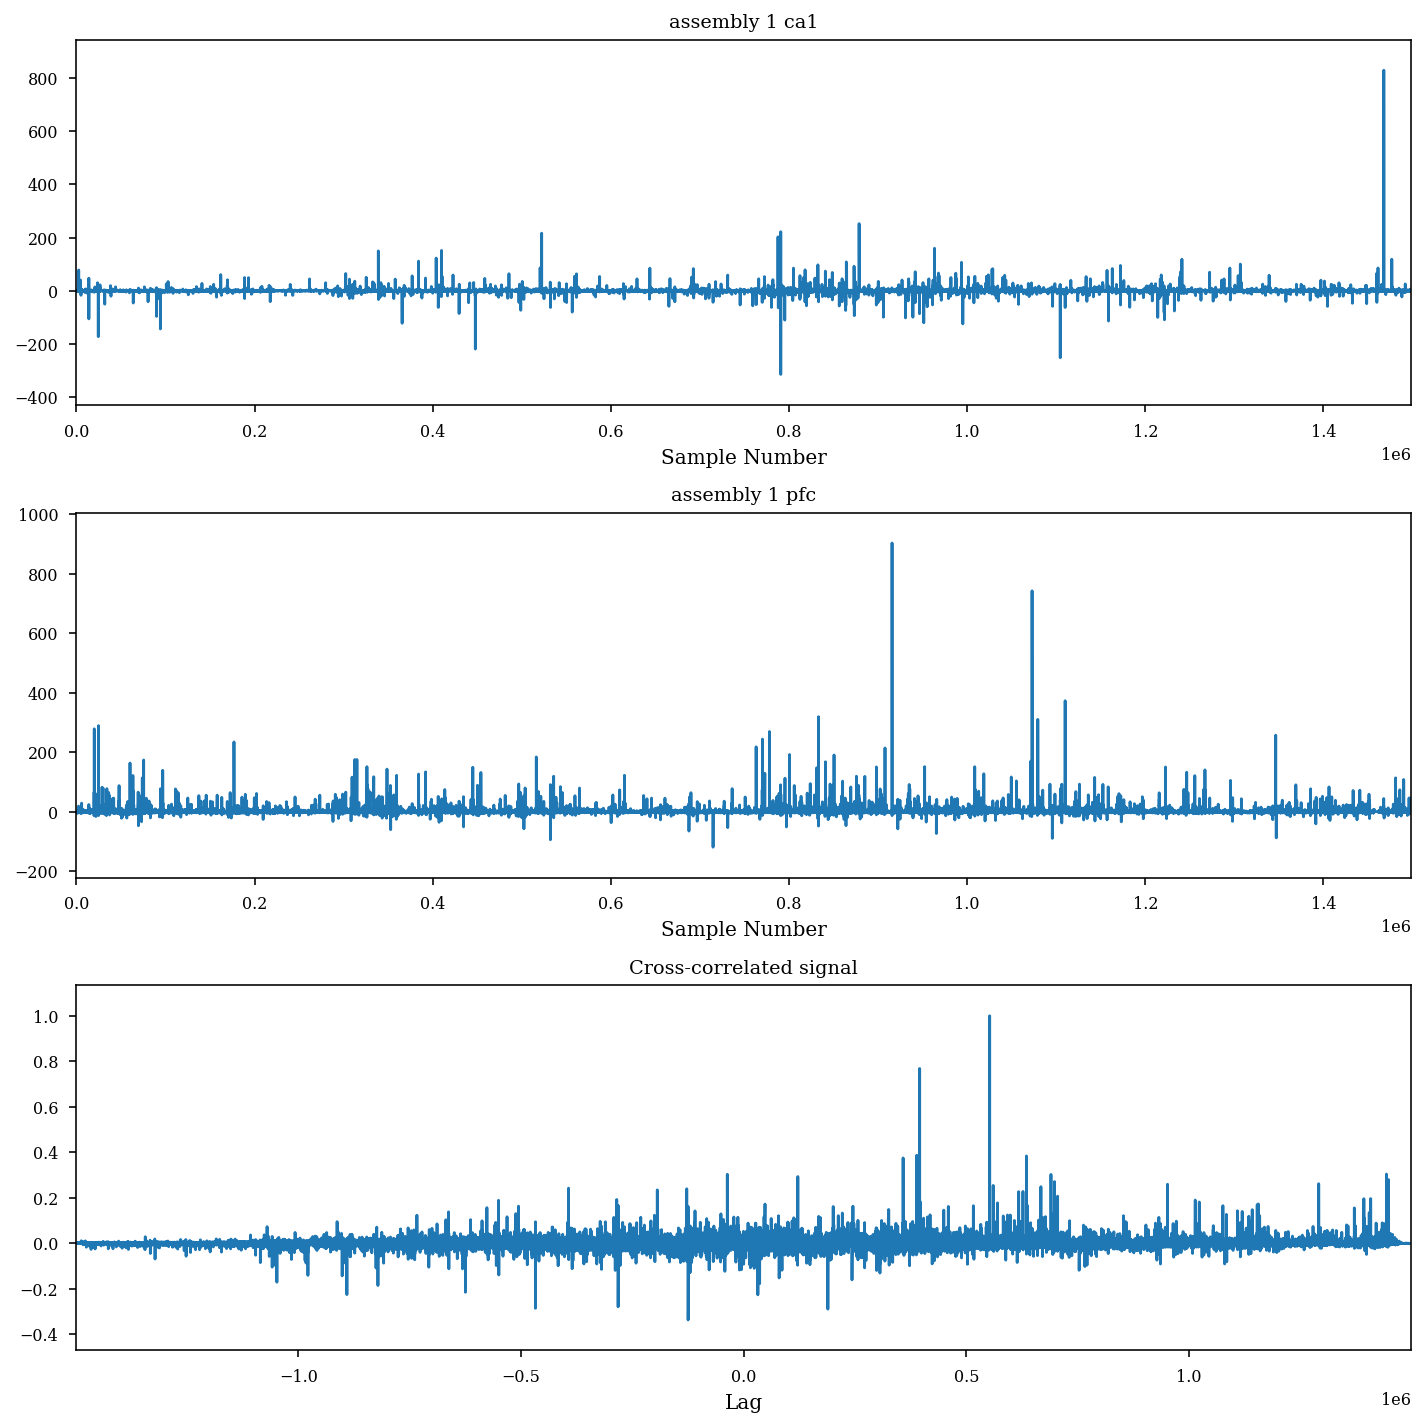

In [95]:
from scipy import signal
corr = signal.correlate(assembly_act[0].data[0], assembly_act[1].data[0])
lags = signal.correlation_lags(len(assembly_act[0].data[0]), len(assembly_act[1].data[0]))
corr /= np.max(corr)


fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, figsize=(10, 10))
ax_orig.plot(assembly_act[0].data[0])
ax_orig.set_title('assembly 1 ca1')
ax_orig.set_xlabel('Sample Number')
ax_noise.plot(assembly_act[1].data[0])
ax_noise.set_title('assembly 1 pfc')
ax_noise.set_xlabel('Sample Number')
ax_corr.plot(lags, corr)
ax_corr.set_title('Cross-correlated signal')
ax_corr.set_xlabel('Lag')
ax_orig.margins(0, 0.1)
ax_noise.margins(0, 0.1)
ax_corr.margins(0, 0.1)
fig.tight_layout()
plt.show()

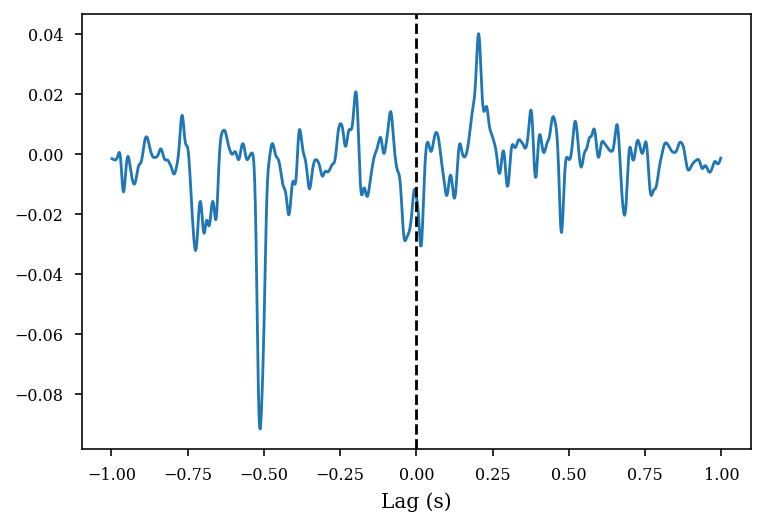

In [99]:
window = 1 # seconds
dt = 0.002
idx = (lags > -window*1/dt) & (lags < window*1/dt)
plt.plot(lags[idx]*dt, corr[idx])
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Lag (s)')
plt.axis('tight')
plt.show()